## Phase calculation: simple example ##

Using gradient descent with momentum

### Sam's notes ###

### Tiff's notes ###
 - Also want a conjugate gradient version!
 - Currently just has a uniform S (laser field) - a very easy improvement will be to use a more realistic version (either a large Gaussian or an image of the real beam) - could either generate here or write a file with the targets (though not really necessary to produce a new file each time!)
 - fftshift completely omitted - but will be easy to include!
 - as in regions, would be good to extract target info from file names (or a useful text file in the folder) rather than entering manually
 - at the moment, running for a defined number of iterations - would be useful to keep going until it stagnates
 - Naming conventions for folders: need to find a good system otherwise things get very confusing very fast! Include everything to be able to get back to this result: random seed, cost function, number of iterations etc

### Preamble; loading target and weighting arrays ###

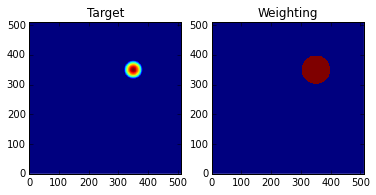

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import os
import theano

%matplotlib inline


# decide what target you want:
targetdir = 'initialisation/example_power2_512_(350,350)_64/'
targetname = os.path.join(targetdir, 'target.dat')
# decide what weighting arrays to use:
weightingdir = os.path.join(targetdir, 'weighting_border_16_noise_1e-06/')
weightingname = os.path.join(weightingdir, 'weight.dat')


target = np.loadtxt(targetname)
weighting = np.loadtxt(weightingname)

N = target.shape[0]/2  # size of SLM is NxN (assuming that padding has doubled size here)

plot_args = {'extent':[0, 2*N, 0, 2*N],
             'interpolation':'None',
             'origin': 'lower'}

fig, axes = plt.subplots(ncols=2)
axes[0].imshow(target, vmin=0, vmax=1, **plot_args)
axes[0].set_title('Target')
axes[1].imshow(weighting, vmin=0, vmax=1, **plot_args)
axes[1].set_title('Weighting')

In [7]:
# Initialise SLM optimisation class:
import theano
import theano.tensor as T

# the code to set up the computation graph transforming the phases
# into an intensity field lives in the slmOptimisation class.
from slm import slmOptimisation

# initialise the phase:
def initial_phase(N):
    """ Return a randomised phase array over [0, 2pi]
    """
    return np.random.uniform(low=0, high=2*np.pi, size=(N,N)).astype(theano.config.floatX)

init_phi = initial_phase(N)

# for this example, the profile $S_{nm}$ is uniform.
s_profile_r = np.ones_like(init_phi).astype(theano.config.floatX)
s_profile_i = np.ones_like(init_phi).astype(theano.config.floatX)
mat_zeros = np.zeros((2*N, 2*N), dtype=theano.config.floatX)

slmOpt = slmOptimisation(target, init_phi, A0=1.0/1000) # fudge factor! Need to stabilise this...

This is the crucial part, where we define the __cost__ function. Here we simply take the difference between the reconstruction and the target, square and sum.  Differentiation of this cost function happens automatically further downstream.
$$ C = \sum_{nm} (T_{nm} - |E^{out}_{nm}|^2)^2 $$

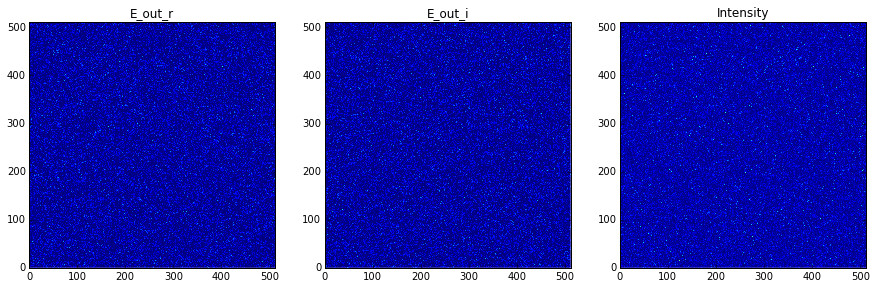

In [9]:
# we now define a cost function to use, squared error for now.
cost = T.sum(T.pow((slmOpt.E_out_2 - target)*weighting, 2))

# compile a function to calculate cost
f_cost = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], cost, on_unused_input='warn')
f_cost(s_profile_r, s_profile_i, mat_zeros)

# compile field output functions:
f_E_out = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], [slmOpt.E_out_r, slmOpt.E_out_i], on_unused_input='warn')
f_E_out_2 = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], slmOpt.E_out_2, on_unused_input='warn')

# visualise the output given the initial phi field
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('E_out_r')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('E_out_i')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

In [10]:
# create symbolic gradient
grad = T.grad(cost, wrt=slmOpt.phi)

# and define a simple momentum update scheme (as a graph)
l_rate = 0.01   # 'learning rate'
momentum = 0.95 # momentum decay
updates = ((slmOpt.phi, slmOpt.phi - l_rate * slmOpt.phi_rate),
           (slmOpt.phi_rate, momentum*slmOpt.phi_rate + (1.-momentum)*grad))

# now actually compile a function to evaluate this gradient:
print "Compiling update function..."
update = theano.function([slmOpt.S_r, slmOpt.S_i, slmOpt.zero_matrix], 
                         cost, 
                         updates=updates,
                         on_unused_input='warn')
print "...done"

C = update(s_profile_r, s_profile_i, mat_zeros)

Compiling update function...
...done


Perform N steps of gradient descent with momentum, and plot.

NB you can press Shift + Enter repeatedly on this cell to incrementally
perform the gradient descent. This is particularly useful when initially testing things out, as a quick check that the minimisation is going ahead in a sensible way!

Initial C: 140.177559671
0 1.40e+02
100 1.32e+02
200 1.25e+02
300 1.19e+02
400 1.15e+02
500 1.11e+02
600 1.07e+02
700 1.04e+02
800 1.02e+02
900 9.96e+01
1000 9.75e+01
1100 9.55e+01
1200 9.37e+01
1300 9.21e+01
1400 9.08e+01
1500 8.97e+01
1600 8.88e+01
1700 8.81e+01
1800 8.73e+01
1900 8.67e+01
2000 8.61e+01
2100 8.55e+01
2200 8.50e+01
2300 8.45e+01
2400 8.41e+01
2500 8.37e+01
2600 8.33e+01
2700 8.30e+01
2800 8.27e+01
2900 8.24e+01
3000 8.21e+01
3100 8.19e+01
3200 8.16e+01
3300 8.14e+01
3400 8.11e+01
3500 8.09e+01
3600 8.07e+01
3700 8.05e+01
3800 8.03e+01
3900 8.00e+01
4000 7.98e+01
4100 7.96e+01
4200 7.95e+01
4300 7.93e+01
4400 7.91e+01
4500 7.89e+01
4600 7.87e+01
4700 7.85e+01
4800 7.83e+01
4900 7.81e+01
5000 7.79e+01
5100 7.77e+01
5200 7.75e+01
5300 7.73e+01
5400 7.71e+01
5500 7.69e+01
5600 7.67e+01
5700 7.65e+01
5800 7.64e+01
5900 7.62e+01
6000 7.60e+01
6100 7.59e+01
6200 7.57e+01
6300 7.56e+01
6400 7.54e+01
6500 7.53e+01
6600 7.52e+01
6700 7.51e+01
6800 7.49e+01
6900 7.48e+01
7000 7.

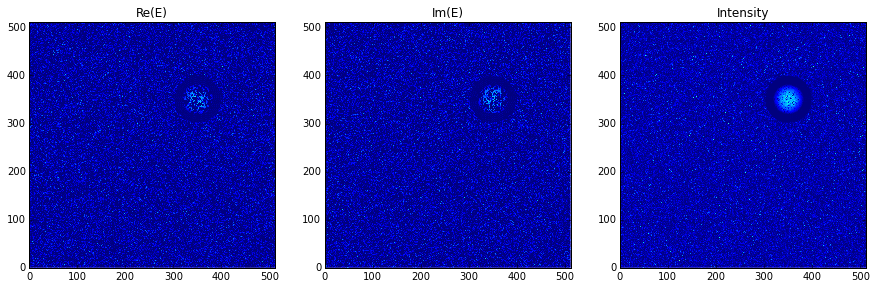

In [12]:
N_steps = 20000
print 'Initial C: {}'.format(C)
last_C = C
n = 0
for n in range(N_steps):
    C = update(s_profile_r, s_profile_i, mat_zeros)
    if np.mod(n, 100) == 0:
        print '{:d} {:.2e}'.format(n, float(C))

# make plots
E_out = f_E_out(s_profile_r, s_profile_i, mat_zeros)
E2_out = f_E_out_2(s_profile_r, s_profile_i, mat_zeros)

fig, (ax1a, ax1b, ax2) = plt.subplots(ncols=3, figsize=(15,15))
ax1a.imshow(E_out[0], vmin=0, vmax=3, **plot_args)
ax1a.set_title('Re(E)')
ax1b.imshow(E_out[1], vmin=0, vmax=3, **plot_args)
ax1b.set_title('Im(E)')
ax2.imshow(E2_out, vmin=0, vmax=3, **plot_args)
ax2.set_title('Intensity');

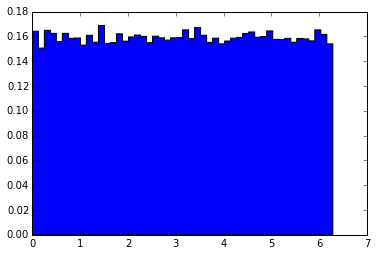

In [13]:
# Check the phase field is sane:
input_phi = np.mod(slmOpt.phi.get_value(), 2*np.pi)
n, bins, patches = plt.hist(input_phi.flatten(), 50, normed=1, histtype='stepfilled')

testdir = os.path.join(weightingdir, 'testcost1/') # Use a more useful naming convention!
if not os.path.exists(testdir):
    os.makedirs(testdir)

# Save the phase field:
np.savetxt(os.path.join(testdir, 'phi'), input_phi)

# Save the calculated output
np.savetxt(os.path.join(testdir, 'intensity'), E2_out)

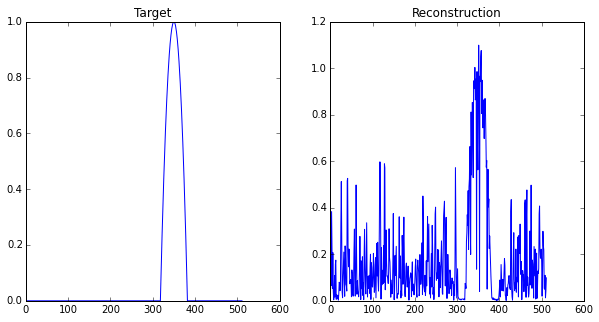

In [14]:
# Plot a cross-section through
fig, axes = plt.subplots(ncols=2, figsize=(10,5))
axes[0].plot(target[350,:])
axes[0].set_title('Target')
axes[1].plot(E2_out[350,:])
axes[1].set_title('Reconstruction')

This is a rather poor reconstruction - vortices everywhere!